# Piecewise linear functions on triangulations

We test the two OMP algorithm on functions in two dimensions, $[0,1]^2$, that is we take $V = H_0^1([0,1]^2)$. We are approximating solutions $u(a(y))$ of the diffusion

We consider a dyadic level-$N$ uniform grid with spacing $\Delta x_{(N)} = 2^{-N}$. The solution is computed on the regular triangulation on this grid, evidently with $h=2^{-N}$. The field $a$ is a pw-constant function on a typically coarser grid, with spacing say $2^{-N_a}$, where $N_a \le N$. 

The dictionary $\mathcal{D}$ for the OMP algorithms consists of the representers of local integration, where the kernel for the local integration are hat-functions. The hat functions we consider are on the squares of size $2^{-N_\mathrm{hat}}$, again with $N_{\mathrm{hat}} \le N$.

That is, if $\mathrm{Hat}_{i,j}$ is the pw linear hat function on the square $[i 2^{-N_{\mathrm{hat}}}, (i+1) 2^{-N_{\mathrm{hat}}}) \times [j 2^{-N_{\mathrm{hat}}}, (j+1) 2^{-N_{\mathrm{hat}}})$, then $\mathcal{D}^{\mathrm{hat}}$ is the collection of functions $\omega_{i,j}$ such that
$$
\langle f, \omega_{i,j}\rangle_{H_0^1} = \int_{[0,1]^2} f \, \mathrm{Hat}_{i,j} \, \mathrm{d}x
$$

The measurement space $W_m$ is constructed such as to minimised $\beta(V_n, W_m)$, where $V_n$ is the provided approximation space. In this case $V_n$ is the space of random the solutions $u(a(y))$

In [2]:
import numpy as np
import scipy as sp
import math
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

### Now we are going to set up a full dictionary of local integration points

And look at projection errors as we decrease the width and the spacing. The code below is run on a cluster from the ```pyApproxTools/scripts/02_2d_PW_omp.py``` script. The results are processed and displayed in the next cell.

```
np.random.seed(3)

fem_div = 7
field_div = 2

n = 20
m = 200

try:
    width = int(sys.argv[1])
except IndexError:
    print("Usage: " + sys.argv[0] + " width")
    sys.exit(1)

# Create Vn - an orthonormalised reduced basis
Vn, fields = pat.make_pw_reduced_basis(n, field_div=field_div, fem_div=fem_div)
Vn = Vn.orthonormalise()

Wms_c = []
Wms_wc = []

bs_c = np.zeros(m) 
bs_wc = np.zeros(m) 

print('Construct dictionary of local averages...')
D = pat.make_pw_hat_rep_dict(fem_div, width=width)

print('Greedy basis construction...')
cbc = pat.CollectiveOMP(D, Vn, Wm=pat.PWBasis(), verbose=True)
Wm_c = cbc.construct_to_m(m)
Wm_c_o = Wm_c.orthonormalise()
Wms_c.append(Wm_c)
Wm_c_o.save('Wm_c_{0}'.format(width))

wcbc = pat.WorstCaseOMP(D, Vn, Wm=pat.PWBasis(), verbose=True)
Wm_wc = wcbc.construct_to_m(m)
Wm_wc_o = Wm_wc.orthonormalise()
Wms_wc.append(Wm_wc)
Wm_wc_o.save('Wm_wc_{0}'.format(width))

# For efficiency it makes sense to compute the basis pair and the associated
# cross-gramian only once, then sub sample it as we grow m...
BP_c_l = pat.BasisPair(Wm_c_o, Vn)
BP_wc_l = pat.BasisPair(Wm_wc_o, Vn)

for i in range(n, m):
    BP_c =  BP_c_l.subspace(Wm_indices=slice(0,i))
    BP_wc =  BP_wc_l.subspace(Wm_indices=slice(0,i))

    bs_c[i] = BP_c.beta()
    bs_wc[i] = BP_wc.beta()

np.save('bs_c_{0}'.format(width), bs_c)
np.save('bs_wc_{0}'.format(width), bs_wc)
```

In [3]:
fem_div = 7
field_div = 2

n = 20

widths = [2**i for i in range(fem_div-3)]

# Import data
bs_cs = []
bs_wcs = []
m = bs_c.shape[1]

Wms_c = []
Wms_wc = []
for width in widths:
    Wms_c.append(pat.PWBasis(file_name='../../scripts/omp/Wm_c_{0}.npz'.format(width)))
    Wms_wc.append(pat.PWBasis(file_name='../../scripts/omp/Wm_wc_{0}.npz'.format(width)))
    
    bs_c.append(np.load('../../omp/scripts/bs_c_{0}.npy'.format(width)))
    bs_wc.append(np.load('../../omp/scripts/bs_wc_{0}.npy'.format(width)))

max 1 Coll: 3.67996690515 WC: 3.1369235123
max 2 Coll: 3.28223779738 WC: 2.74651431478
max 4 Coll: 3.00578311882 WC: 2.34849353503
max 8 Coll: 2.62487528996 WC: 1.89616586647


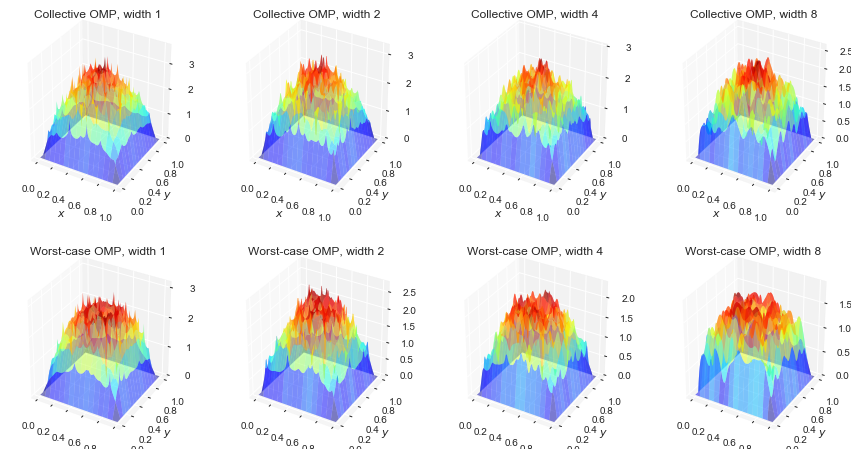

In [4]:
# Lets plot our measurment locations

fig = plt.figure(figsize=(15, 8))

for i, width in enumerate(widths):
    meas_c = Wms_c[i].vecs[0]
    for vec in Wms_c[i].vecs[1:]:
        meas_c += vec

    meas_wc = Wms_wc[i].vecs[0]
    for vec in Wms_wc[i].vecs[1:]:
        meas_wc += vec
    print('max ' + str(width) + ' Coll: ' + str(meas_c.values.max()) + ' WC: ' + str(meas_wc.values.max()))
    ax1 = fig.add_subplot(2, len(widths), i+1, projection='3d')
    meas_c.plot(ax1, title='Collective OMP, width {0}'.format(width))
    ax2 = fig.add_subplot(2, len(widths), i+1+len(widths), projection='3d')
    meas_wc.plot(ax2, title='Worst-case OMP, width {0}'.format(width))


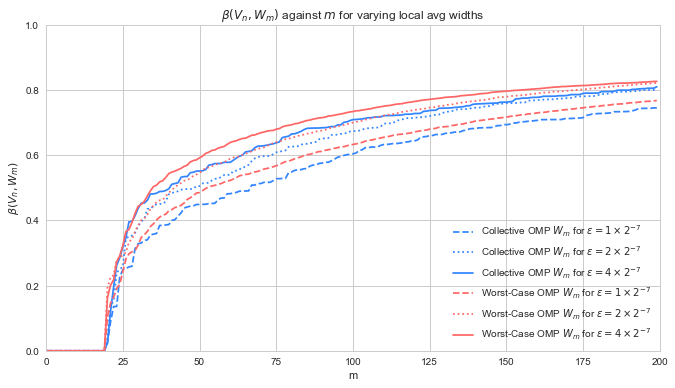

In [11]:
sns.set_style('whitegrid')
line_style = ['--', ':', '-', '-', '-.']
pals = [ 'Blues_r', 'Reds_r', 'Greens_r', 'Purples_r']

bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 1s02/255)

axs = []

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for varying local avg widths')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

sns.set_palette(pals[0])
cp = sns.color_palette()
for i, width in enumerate(widths[:-1]):
    plt.plot(range(m), bs_c[i, :], line_style[i], label=r'Collective OMP $W_m$ for $\varepsilon={{{0}}} \times 2^{{{1}}}$'.format(width, -fem_div), color=bl)#cp[i])
    
sns.set_palette(pals[1])
cp = sns.color_palette()
for i, width in enumerate(widths[:-1]):    
    plt.plot(range(m), bs_wc[i, :], line_style[i], label=r'Worst-Case OMP $W_m$ for $\varepsilon={{{0}}} \times 2^{{{1}}}$'.format(width, -fem_div), color=re)#cp[i])

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,200], ylim=[0,1])#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.savefig('2dCOMPvsWCOMPLocAvg.pdf')
plt.show()


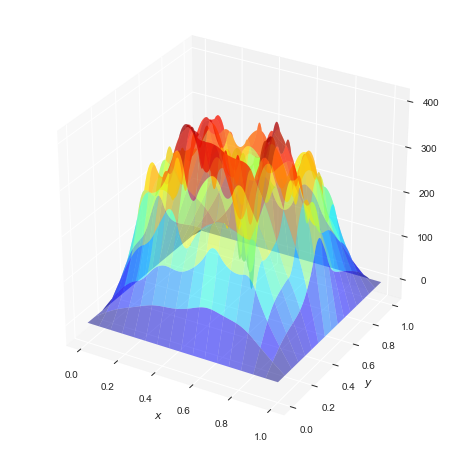

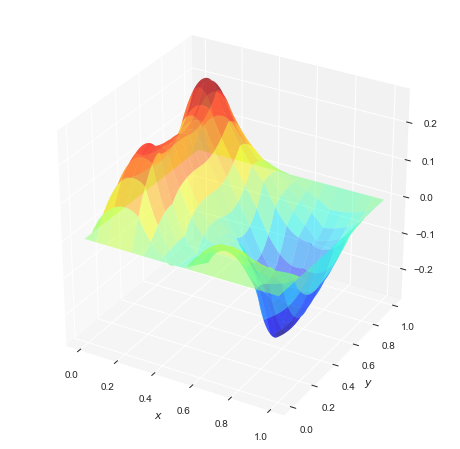

In [11]:
v = Wm_wc.vecs[0]
for w in Wm_wc.vecs[1:]:
    v += w

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
v.plot(ax1)
plt.show()

fig = plt.figure(figsize=(8, 8))
ax2 = fig.add_subplot(1, 1, 1, projection='3d')
Vn.vecs[2].plot(ax2)
plt.show()